# Content Mining Models

## Table of Contents
##### [1. Data Preprocessing and Imports](#preprocessing)
##### [1.1 Keyword extraction](#sampling)
##### [1.1 Keyword extraction](#keywords)
##### [2. Models](#models)
###### [2.1. Cosine Similarity](#cosine)
###### [2.2. LSI Model](#lsi)
###### [2.3. Mixture Model](#mixture)
##### [3. Interpretation and Evaluation](#interpretation_evaluation)

<a id='preprocessing'></a>
## 1. Data Preprocessing and Imports

##### Packages to install in cmd upfront:

conda install -c conda-forge selenium <\br>
conda install -c anaconda nltk <\br>
pip install rake-nltk

In [97]:
import pandas as pd
import numpy as np
import nltk
import inflect
import re, string, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.metrics import jaccard_score, pairwise_distances_chunked, mean_squared_error, mean_absolute_error

In [98]:
# Import functions module
%run functions.py

In [41]:
#load data
interactions_raw = pd.read_csv(
        'Data/RAW_interactions.csv')
recipes_raw = pd.read_csv(
        'Data/RAW_recipes.csv', parse_dates=['submitted'], infer_datetime_format=True)

In [99]:
#make copies so that we don't have to reload the data after mistakes
interactions_data = interactions_raw.copy()
recipes_data = recipes_raw.copy()

In [100]:
# Rename columns to more explanatory names
recipes_data.rename(columns={"id": "recipe_id"}, inplace=True)

# Fill nan
# recipes_data.fillna("", inplace=True)
# interactions_data.fillna("", inplace=True)

In [101]:
def deal_with_NAs(df):
    df.drop(df[df["name"].isna()].index, inplace =True)
    df["description"].fillna("", inplace=True)
    df.loc[144074, "minutes"]= 25
    df.drop(df[df["name"]=="how to preserve a husband"].index, inplace=True)
    

In [102]:
deal_with_NAs(recipes_data)

<a id='sampling'></a>
### Provisory recipe filter/sampler 

In [103]:
#create an age column for the recipes
recipes_data['age'] = round((2019-recipes_data.submitted.dt.year)+recipes_data.submitted.dt.month/12, 1)

In [104]:
# Calculate average ratings for each recipe

def get_avg_recipe_rating(interactions_df, recipes_df):
    #Average ratings
    num_interactions = interactions_df.groupby("recipe_id")["date"].count()
    #only consider the ratings (>0) into the mean, not the reviews w/o ratings
    mean_ratings = round(interactions_df[interactions_df["rating"]!=0].groupby("recipe_id")["rating"].mean(), 2)
    #merge
    df_rmerged = recipes_df.join(num_interactions, how="left", on="recipe_id").join(mean_ratings, how="left", on="recipe_id")
    df_rmerged = df_rmerged.rename(columns ={"date":"num_interactions", "rating":"avg_rating"})
    return df_rmerged

In [105]:
def filter_byquality(df):
    df.drop(df[(df["n_steps"]==1)&(df["num_interactions"]==1)].index, axis=0, inplace =True)
    print("Shape after removing 1 step recipes w/ low interactions:", df.shape)
    df.drop(df[df["avg_rating"].isna()].index, axis=0, inplace =True)
    print("Shape after removing recipes w/o ratings:", df.shape)
    df.drop(df[(df['minutes']==0)].index, axis=0, inplace=True)
    print('Shape after removing 0 minutes interaction w/ low interactions:', df.shape)

def filter_byinteractions(num_interactions, age, df, older):
    """
    older: boolean
    """
    if (older==True):
        index_remove= df[(df["num_interactions"]<=num_interactions) & (df["age"]>age)]["recipe_id"].index
        df.drop(index_remove, axis=0, inplace=True)
        print(f'Shape after filtering recipes less than {num_interactions} and older than {age} years old: {df.shape}')
    else:
        index_remove= df[(df["num_interactions"]<=num_interactions) & (df["age"]<=age)]["recipe_id"].index
        df.drop(index_remove, axis=0, inplace=True)
        print(f'Shape after filtering recipes less than {num_interactions} and younger than {age} years old: {df.shape}')

In [106]:
def choose_best(interactions, ratings, n_dupl):
    # number of interaction are different -> there exists a maximum
    if((len(interactions) != len(set(interactions)))) :
        return interactions.idxmax(axis=1)
    else:# return the maximum rating or any of the duplicate recipes
        return ratings.idxmax(axis=1)

def remove_duplicates(df):
    dupl_recipes = pd.DataFrame(df[df["name"].duplicated(keep=False)])
    dupl_rgrouped= dupl_recipes.groupby('name').groups
    
    to_keep = []
    
    for name in dupl_rgrouped:
        n_dupl = len(dupl_rgrouped[name])
        if(n_dupl == 2):
            index1=dupl_rgrouped[name][0]
            index2=dupl_rgrouped[name][1]
            
            interactions = dupl_recipes.loc[[index1, index2], ['num_interactions']].num_interactions
            ratings = dupl_recipes.loc[[index1, index2], ['avg_rating']].avg_rating
            to_keep.append(choose_best(interactions, ratings, n_dupl))
        elif (n_dupl==3):
            index1=dupl_rgrouped[name][0]
            index2=dupl_rgrouped[name][1]
            index3=dupl_rgrouped[name][2]
            
            interactions = dupl_recipes.loc[[index1, index2, index3], ['num_interactions']].num_interactions
            ratings = dupl_recipes.loc[[index1, index2, index3], ['avg_rating']].avg_rating
            to_keep.append(choose_best(interactions, ratings, n_dupl))
        else:
            print("Error")
            break
            
        df.drop(df.index.intersection(to_keep), axis=0, inplace=True)
    print('Shape after dropping duplicates:', df.shape)

In [107]:
#generate URL for every recipe
def generate_URL(df):
    df["URL"] = df.apply(lambda row: "https://www.food.com/recipe/"+" ".join(row["name"].split()).replace(" ", "-") 
                         +"-"+str(row["recipe_id"]), axis=1)
    print(f'URLs created for each of the {len(df.index)} recipes')
    return df

In [108]:
recipes_data = get_avg_recipe_rating(interactions_data, recipes_data)
filter_byinteractions(15,8,recipes_data, older=True)
filter_byinteractions(10,8,recipes_data, older=False)
filter_byquality(recipes_data)
remove_duplicates(recipes_data)
recipes_data = generate_URL(recipes_data)

Shape after filtering recipes less than 15 and older than 8 years old: (21913, 15)
Shape after filtering recipes less than 10 and younger than 8 years old: (11151, 15)
Shape after removing 1 step recipes w/ low interactions: (11151, 15)
Shape after removing recipes w/o ratings: (11151, 15)
Shape after removing 0 minutes interaction w/ low interactions: (11103, 15)
Shape after dropping duplicates: (11090, 15)
URLs created for each of the 11090 recipes


In [109]:
recipes_data.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,age,num_interactions,avg_rating,URL
15,chicken lickin good pork chops,63986,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,"['dredge pork chops in mixture of flour , salt...",here's and old standby i enjoy from time to ti...,"['lean pork chops', 'flour', 'salt', 'dry must...",7,16.5,19,4.88,https://www.food.com/recipe/chicken-lickin-goo...
36,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",8,17.3,113,4.34,https://www.food.com/recipe/how-i-got-my-famil...
43,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"['60-minutes-or-less', 'time-to-make', 'course...","[223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]",6,"['brown the meat & drain fat', 'stir in sugar ...",just the thing for a day when you're wanton so...,"['ground beef', 'sugar', 'prepared yellow must...",8,16.3,21,4.20,https://www.food.com/recipe/immoral-sandwich-f...
53,land of nod cinnamon buns,22526,35,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"['rolls', 'brown sugar', 'instant vanilla pudd...",6,17.2,51,4.73,https://www.food.com/recipe/land-of-nod-cinnam...
67,never weep whipped cream,74805,5,87877,2003-11-01,"['15-minutes-or-less', 'time-to-make', 'course...","[276.3, 45.0, 2.0, 1.0, 3.0, 91.0, 0.0]",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...","['whipping cream', 'vanilla instant pudding mi...",4,16.9,80,4.99,https://www.food.com/recipe/never-weep-whipped...


<a id='keywords'></a>
### Keyword extraction

In [15]:
# Preprocess ingredients and save as String
for index, row in recipes_data.iterrows():
    ingredientlist = row['ingredients']
    ingredientlist = row['ingredients'].replace('[', '').replace(', ', '').replace(']', '').replace('and', '\'').split("\'")
    ingredientlist = list(filter(None, ingredientlist))
    ingredientlistString = ""
    for i in ingredientlist:
        ingredientlistString = ingredientlistString + i
    recipes_data.at[index, 'ingredients'] = ingredientlistString

In [37]:
# Extract keywords for free text features
# recipes_data = get_keywords(recipes_data, "steps", "steps_keywords")
# recipes_data = get_keywords(recipes_data, "description", "description_keywords")
# interactions_data = get_keywords(interactions_data, "review", "review_keywords")

In [32]:
recipes_data.head(3)

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,ingredients,n_ingredients,age,num_interactions,avg_rating,URL,steps_keywords,description_keywords
recipe_id,,,,,,,,,,,,,,,
63986,chicken lickin good pork chops,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,lean pork chopsfloursaltdry mustardgarlic powd...,7,16.5,19,4.88,https://www.food.com/recipe/chicken-lickin-goo...,large skilletplace browned pork chops crock po...,old newspaper clipping standby years ago enjoy...
25775,how i got my family to eat spinach spinach ca...,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,frozen chopped spinacheggsaltblack pepperonion...,8,17.3,113,4.34,https://www.food.com/recipe/how-i-got-my-famil...,itin 350 degreesplace spinach ingredients exce...,also eats never tried ... often passed hot :) ...
58224,immoral sandwich filling loose meat,35,37183,2003-04-04,"['60-minutes-or-less', 'time-to-make', 'course...","[223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]",6,ground beefsugarprepared yellow mustardbeercay...,8,16.3,21,4.20,https://www.food.com/recipe/immoral-sandwich-f...,mostly cooked awaylay slices pepper sugar must...,pile well inhibitions hot loose meat bun thing...


<a id='user-interaction'></a>
### Creating user-activity data & filtered interactions data

In [110]:
def impute_average_rating(row, df_uactivity):
    if (row['rating'] == 0):
        imputed_rating = round(df_uactivity.loc[df_uactivity.user_id == row.user_id, 'uavg_rating'].values[0], 0)
        return imputed_rating
    else:
        return row.rating

def get_user_activity_df(df):
    #Create a user activity dataframe
    df_uactivity = df.groupby('user_id')['rating'].value_counts().unstack().fillna(0)
    cols = list(df_uactivity)
    df_uactivity['total_interactions'] = df_uactivity[cols].sum(axis=1)
    df_uactivity['total_ratings'] = df_uactivity['total_interactions']-df_uactivity[0]
    return df_uactivity

def create_activity_data(interactions_df, num_interactions):
    df_uactivity = get_user_activity_df(interactions_df[['recipe_id','user_id', 'rating']])
    df_uactivity = df_uactivity[df_uactivity['total_interactions']>=7]
    print(f'Shape after filtering out users with less than {num_interactions} interactions: {df_uactivity.shape}')
    #create average user ratings as behavior
    df_uactivity['uavg_rating'] = df_uactivity.iloc[:,1:6].apply(
        lambda row: np.round(np.ma.average(list(range(1,6)), 
                                           weights = (row[1], row[2], row[3], row[4], row[5])),1), axis = 1)
    
    df_uactivity = df_uactivity.reset_index()
    df_uactivity.columns.set_names(None, inplace = True)
    
    #drop users that only have only reviews but no ratings
    df_uactivity.drop(df_uactivity[df_uactivity.total_ratings == 0].index, inplace=True, axis=0)
    return df_uactivity

def filter_interactions_data(interactions_df, recipes_data, num_interactions):
    df_uactivity = create_activity_data(interactions_df, num_interactions)
    # 1. Create Filter for interations with filtered df_uactivity -> Only interactions from active users remain
    user_filter = pd.merge(df_uactivity[['user_id']], interactions_data[['recipe_id','user_id', 'rating']], how = 'left', on ='user_id')
    # 2. Filter interactions with active recipes -> Only interactions from active users and clean recipes remain
    interactions = pd.merge(recipes_data[['recipe_id']], user_filter[['recipe_id', 'user_id', 'rating']], on = 'recipe_id', how ='inner')
    zero_ratings = len(interactions.loc[interactions.rating==0])
    interactions['rating'] = interactions.apply(lambda row: impute_average_rating(row, df_uactivity), axis=1)
    print(f'Number of imputed ratings: {zero_ratings}')
    return interactions


In [111]:
interactions = filter_interactions_data(interactions_data, recipes_data, num_interactions=7)
interactions.head()

Shape after filtering out users with less than 7 interactions: (17099, 8)


C:\Users\Andi\Anaconda3\lib\site-packages\numpy\ma\extras.py:608: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


Number of imputed ratings: 8169


,recipe_id,user_id,rating
0,63986,4470,5.0
1,63986,28649,4.0
2,63986,37471,5.0
3,63986,60992,5.0
4,63986,75497,5.0


In [112]:
def get_rating_dist(df_column):
    ratings_series=pd.Series(df_column.value_counts())
    ratings_series.plot.bar()
    print(f'Percent of 5 star rating interactions: {round((ratings_series.loc[5]/len(df_column)*100),2)}%')
    print(f'Percent of 4 star rating interactions: {round((ratings_series.loc[4]/len(df_column)*100),2)}%')
    print(f'Percent of 3 star rating interactions: {round((ratings_series.loc[3]/len(df_column)*100),2)}%')
    print(f'Percent of 2 star rating interactions: {round((ratings_series.loc[2]/len(df_column)*100),2)}%')
    print(f'Percent of 1 star rating interactions: {round((ratings_series.loc[1]/len(df_column)*100),2)}%')

Percent of 5 star rating interactions: 79.63%
Percent of 4 star rating interactions: 15.58%
Percent of 3 star rating interactions: 3.29%
Percent of 2 star rating interactions: 1.03%
Percent of 1 star rating interactions: 0.47%


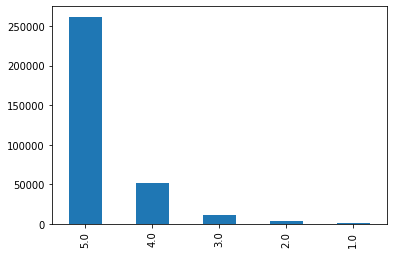

In [113]:
#Let's look at the distribution of ratings
get_rating_dist(interactions.rating)

### NLP Preprocessing

In [114]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [115]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    #stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [116]:
def get_processed(data):
    processed = pd.DataFrame(data=[],columns = ['recipe_id', 'content'])
    new_texts = []

    for i in range(0, len(data)):
        recipe_id = data['recipe_id'].iloc[i]
        words = nltk.word_tokenize(data['content'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[recipe_id, text]], columns=['recipe_id', 'content'])
        new_texts.append(text)
        processed = processed.append(dfnew,ignore_index = True)

    return processed

In [117]:
#checking if all recipes are in interactions
helper = pd.unique(interactions_data['recipe_id'])
df_rfiltered = recipes_data[recipes_data.recipe_id.isin(helper)]
print(recipes_data.shape)
df_rfiltered.shape

(11090, 16)


(11090, 16)

In [118]:
def create_input (df, column_names):
    df_content = df
    df_content['content'] = df.loc[:, (column_names)].apply(lambda texts: ' '.join(texts), axis=1)
    df_content.drop(columns = column_names, inplace = True)
    df_content['content']=df_content['content'].apply(lambda text: ' '.join(text.split()))
    return df_content

In [119]:
#flatten steps data
df_rfiltered.steps = df_rfiltered.loc[:, ('steps')].str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","").copy()

#create content df
df_rfiltered = create_input(df_rfiltered[['recipe_id', 'name', 'description', 'steps']], ['name', 'description', 'steps'])

df_rfiltered.head()

C:\Users\Andi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Andi\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Andi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

,recipe_id,content
15,63986,chicken lickin good pork chops here's and old ...
36,25775,how i got my family to eat spinach spinach cas...
43,58224,immoral sandwich filling loose meat just the t...
53,22526,land of nod cinnamon buns i have made this sev...
67,74805,never weep whipped cream i don't know where i ...


In [120]:
content_processed = get_processed(df_rfiltered)
content_processed.shape

(11090, 2)

In [16]:
# sample = df_content.sample(n=1000, replace=False, random_state=42)\
#                  .reset_index()\
#                  .drop(columns=['index'])
# sample.head()

,recipe_id,content
0,94947,crab filled crescent snacks crescent roll reci...
1,429010,curried bean salad serve works nicely family t...
2,277542,delicious steak with onion marinade took estim...
3,78450,pork tenderloin with hoisin another keeper enj...
4,80012,mixed baby greens with oranges grapefruit and ...


<a id='models'></a>
## 2. Models

### 2.0 General functions

### 2.0.1 Recommendations functions & Coverage

In [121]:
#return top k predicted ratings in readable form 

# IMPORTANT: must set the dataframe for recipe_info index == recipe_id!
def get_user_recommendations(user_id, similarity, content, interactions_data, recipe_info, k):
    #get top k recipe ids
    topk_recipes, predictions = get_topk_recipes(user_id, similarity, content, interactions_data, k)
    info = recipe_info.loc[topk_recipes]
    info['prediction'] = predictions
    return info

def get_topk_recipes(user_id, similarity, content, interactions, k):
    prediction_df = get_user_preference(user_id,similarity, content, interactions)
    #take only the not yet seen recipes
    new_predictions = prediction_df[prediction_df['has_rated'] == False]
    #sort predictions
    ordered_predictions = new_predictions.sort_values(by='prediction', ascending=False)
    #get recipe_id array
    topk_recipes = ordered_predictions.index[:k].values
    predictions = ordered_predictions.prediction[:k].values
    return topk_recipes, predictions

In [122]:
#return predictions for 1 user
def get_user_preference(user_id, similarity, content, interactions_data):
    #prepare similarity dataframe
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions_data[interactions_data['user_id']==user_id]['recipe_id'].values
    #get similarities of ALL recipes w/ already rated recipes of user
    sim_rated_all = sim.loc[rated_recipes, :]
    #get ratings of already rated recipes
    ratings = get_reshaped_ratings(user_id, interactions_data)
    #compute weighted similarities between all recipes and already rated recipes
    weighted_sim = np.dot(ratings,sim_rated_all)
    #compute normalization constant
    norm_const = np.array(np.abs(sim_rated_all).sum(axis=0))
    #return sorted predictions
    pref_predictions = weighted_sim/norm_const
    flat_predictions = [item for sublist in pref_predictions for item in sublist]
    #return df with recipe id also
    prediction_df = pd.DataFrame(flat_predictions, index =content['recipe_id'].values, columns =['prediction'])
    #indicate the already tried recipes
    prediction_df['has_rated'] = prediction_df.index.isin(rated_recipes)
    #order predictions
    return prediction_df

#arrange ratings for matrix multiplication
def get_reshaped_ratings(user_id, interactions_data):
    ratings = interactions_data[interactions_data['user_id']==user_id]
    ratings.set_index('recipe_id', inplace=True)
    ratings.index.set_names(None, inplace = True)
    ratings.drop(columns='user_id', inplace=True)
    ratings = ratings.transpose()
    ratings.rename(index={'rating':user_id}, inplace=True)
    return ratings

In [123]:
#Source: https://github.com/statisticianinstilettos/recmetrics/

# input = nested_recommendations from make_all_recommendations
def catalog_coverage(predicted, catalog, k):
    """
    Computes the catalog coverage for k lists of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    Returns
    ----------
    catalog_coverage:
        The catalog coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage

In [124]:
#TODO
def make_all_recommendations(user_ids, k):
    """
    Params:
    user_ids = list of user ids
    k= number of recommendations
    ... to be continued
    
    Returns:
    nested_recommendations = nested list of recommended recipe_ids for each user in param list
    example:[[rid1, rid20, rid30...], [rid1, rid20, rid30...],[rid1, rid20, rid30...]]
    """
    return nested_recommendations

### 2.0.2 Prediction function for RMSE

In [125]:
#prediction for 1 already rated recipe based on similarities to other already rated recipes

def get_one_prediction(similarity, content, interactions, user_id, recipe_id):
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions[interactions['user_id']==user_id]['recipe_id'].values
    #get similarities of to be predicted recipe rating with already rated recipes by user x
    sim_rated = sim.loc[sim.index==recipe_id, rated_recipes].loc[recipe_id].values
    #get ratings of rated recipes
    ratings = interactions[interactions['user_id']==user_id]['rating'].values
    
    actual = interactions.loc[(interactions.user_id==user_id) & (interactions.recipe_id==recipe_id)]['rating'].values[0]
    prediction = np.dot(ratings, sim_rated) /np.array([np.abs(sim_rated).sum(axis=0)])
    return actual, prediction

In [126]:
#only relevant if there is a recipe sample

def get_interaction_processed(processed, interactions):
    #fetch only interactions in the preprocessed sample
    interactions_processed = interactions.loc[interactions.recipe_id.isin(processed.recipe_id)]\
                           .reset_index()\
                           .drop(columns=['index'])
    print(f'Interactions before processing: {len(interactions.index)}\nInteractions covered in sample: {len(interactions_processed.index)}')
    return interactions_processed

<a id='cosine'></a>
### 2.1. Cosine similarity

#### 2.1.1 Tfidf & SVD

In [127]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [128]:
def get_cos_sim_matrix(processed):
    tfidf = TfidfVectorizer(stop_words='english')
    processed['content'] = processed['content'].fillna('')
    tfidf_matrix = tfidf.fit_transform(processed['content'])
    #reduce dimensionality of tfidf matrix
    svd = TruncatedSVD(n_components=10, random_state=42)
    tfidf_truncated = svd.fit_transform(tfidf_matrix) 
    cosine_sim = cosine_similarity(tfidf_truncated,tfidf_truncated)
    return cosine_sim

In [129]:
cosine_sim = get_cos_sim_matrix(content_processed)
cosine_sim.shape

(11090, 11090)

#### 2.1.1.1 Make all recommendations for tfidf/SVD

In [ ]:
recipes_data.set_index('recipe_id', inplace=True)

get_user_recommendations(60992, cosine_sim, processed, interactions, recipes_data, 5)

#### 2.1.1.2 Make all predictions for tfidf/SVD

In [82]:
uids = interactions['user_id'].values
rids = interactions['recipe_id'].values

predictions_cos = []
actual_cos = []

#Make a prediction for each interaction in the interactions df

for i in range(len(interactions)):
    act, pred = get_one_prediction(cosine_sim, content_processed, interactions, uids[i], rids[i])
    predictions_cos.append(pred)
    actual_cos.append(act)

NameError: name 'cosine_sim' is not defined

In [208]:
rmse_cos = mean_squared_error(predictions_cos, actual_cos)**0.5
mae_cos = mean_absolute_error(predictions_cos, actual_cos)
print(f'RMSE: {rmse_cos}, MAE: {mae_cos}')

RMSE: 0.7974036648021893, MAE: 0.48986660107129026


In [96]:
interactions['predicted_rating'] = [item for sublist in predictions_cos for item in sublist]
interactions.head()

NameError: name 'interactions' is not defined

In [97]:
get_rating_dist(round(interactions.predicted_rating))

NameError: name 'get_rating_dist' is not defined

#### 2.1.2 WordEmbeddings

In [ ]:
from gensim.models import Word2Vec 
from gensim.similarities import MatrixSimilarity 
from gensim.matutils import Dense2Corpus

# Create processed vector (TODO: Rewrite Code)
processed_embedding = []
for row in content_processed['content']: 
    processed_embedding.append(row)

# Initialize Word2Vec Model
model = Word2Vec(size = content_processed['content'].size)
model.build_vocab(processed_embedding)

# Train with the corpus
model.train(processed_embedding, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

# Generate Similarity Matrix
embeddings_matrix = MatrixSimilarity(Dense2Corpus(model.wv.syn0.T))

11090


In [ ]:
uids = interactions['user_id'].values
rids = interactions['recipe_id'].values

predictions_cos = []
actual_cos = []

#Make a prediction for each interaction in the interactions df

for i in range(len(interactions)):
    act, pred = get_one_prediction(embeddings_matrix, content_processed, interactions, uids[i], rids[i])
    predictions_cos.append(pred)
    actual_cos.append(act)

Recommendation -> =/= already rated -> Coverage
= recommend highest predicted rating NOT seen yet
-> new prediction for ALL recipes for 1 user


<-> Prediction -> RMSE 

<a id='mixture'></a>
### 2.2. Mixture Model

In [210]:
def get_mix_sim_matrix(processed, lmbda, df_rfiltered):
    cos_sim = get_cos_sim_matrix(processed)
    df_sub = df_rfiltered[['recipe_id', 'n_steps', 'minutes', 'n_ingredients']]
    df_processed = df_sub[df_sub['recipe_id'].isin(processed['recipe_id'])]\
                                                             .set_index('recipe_id')
    
    scaler = StandardScaler()
    X = scaler.fit_transform(df_processed)
    eucl_dis = euclidean_distances(X,X)
    
    eucl_sim = 1/np.exp(eucl_dis)
    mixed_sim = np.add(cos_sim*lmbda,eucl_sim*(1-lmbda)) # assume equally weighted
    
    return mixed_sim

#### Make recommendations based on Mixture Model

#### Make predictions based on Mixture Model

In [ ]:
mixed_sim = get_mix_sim_matrix(content_processed, 0.5, df_rfiltered)
mixed_sim.shape

In [ ]:
uids = interactions['user_id'].values
rids = interactions['recipe_id'].values

predictions_mixed = []
actual_mixed = []

#Make a prediction for each interaction in the interactions df
for i in range(len(interactions)):
    act, pred = get_one_prediction(mixed_sim, content_processed, interactions, uids[i], rids[i])
    predictions_mixed.append(pred)
    actual_mixed.append(act)

In [ ]:
rmse_mixed = mean_squared_error(predictions_mixed, actual_mixed)**0.5
mae_mixed = mean_absolute_error(predictions_mixed, actual_mixed)
print(f'RMSE: {rmse_mixed}, MAE: {mae_mixed}')

In [ ]:
interactions['predicted_rating_mixed'] = [item for sublist in predictions_mixed for item in sublist]
interactions.head()

In [ ]:
get_rating_dist(round(interactions.predicted_rating_mixed))

<a id='interpretation_evaluation'></a>
## 3. Interpretation and Evaluation